In [1]:
import os
from PIL import Image
import cv2
import time
from tqdm import tqdm

import numpy as np
from random import shuffle
import torch
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid


import imgaug as ia
from imgaug import augmenters as iaa

import matplotlib.pyplot as plt
%matplotlib inline

os.environ['CUDA_VISIBLE_DEVICES'] = "-1" # We don't need GPU for this, set as -1 to prevent GPU triggering
DATA_FOLDER="./sample_data/"

In [2]:
image_path = [os.path.join(DATA_FOLDER, i) for i in os.listdir(DATA_FOLDER)]
images = np.array([cv2.cvtColor(cv2.resize(cv2.imread(i), (224,224)), cv2.COLOR_BGR2RGB) for i in image_path])

In [3]:
class Pytorch_dataset_method():
    """Class for Data Loader"""
    def __init__(self, file_list, transform=None):
        """
        Args:
            - file_path: list of image file path
            - transform: optional transform to be used
        """
        self.file_list = file_list
        self.transform = transform
        self.index = 0
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        idx = idx % len(self.file_list)
        img = cv2.cvtColor(cv2.imread(self.file_list[idx]), cv2.COLOR_BGR2RGB)
        #sample = {'image': img}
        sample = img
        
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def __iter__(self):
        return self

    def __next__(self):
        if self.index == len(self):
            shuffle(self.file_list)
            self.index = 0
        self.index += 1
        return self.__getitem__(self.index-1)

In [4]:
dataset = Pytorch_dataset_method(file_list=image_path)

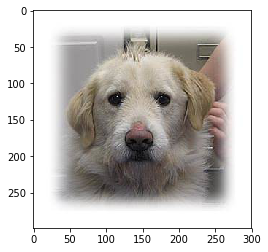

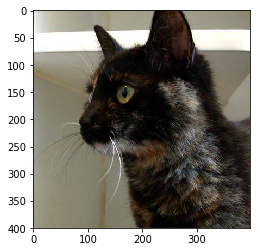

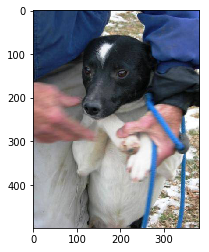

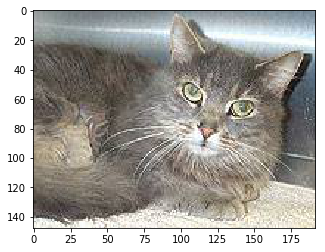

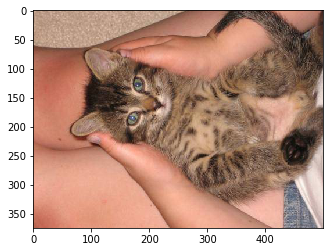

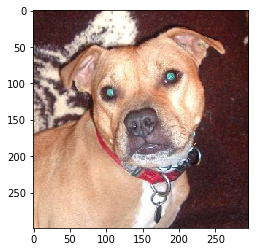

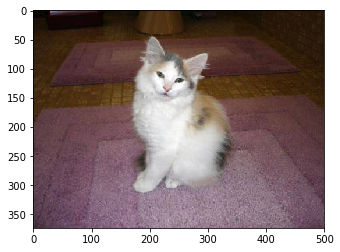

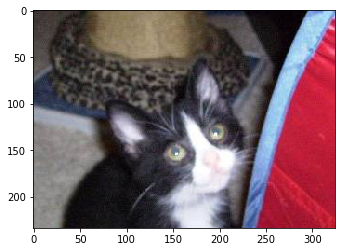

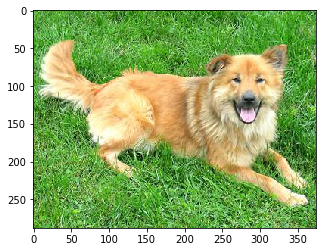

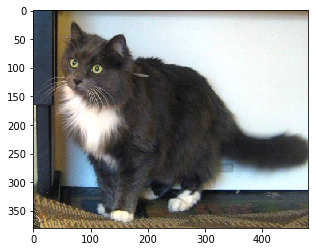

In [5]:
for i in range(len(dataset)):
    im = dataset[i]
    plt.imshow(im)
    plt.show()

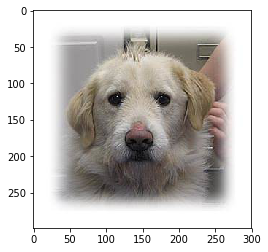

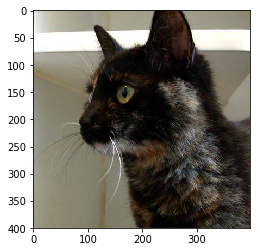

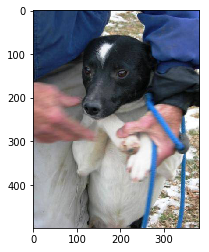

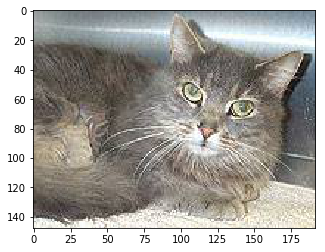

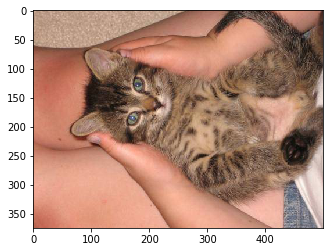

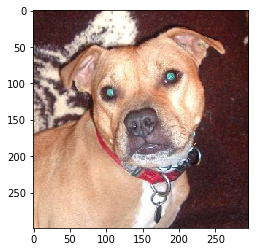

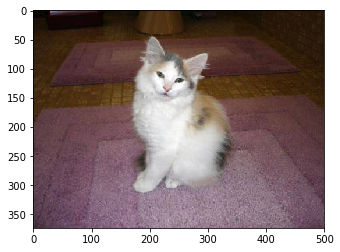

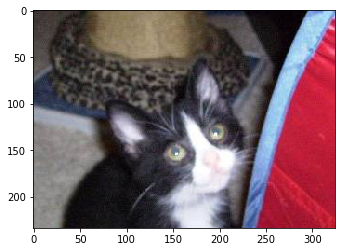

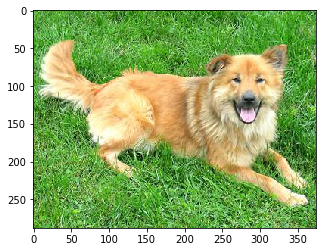

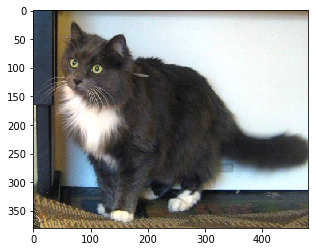

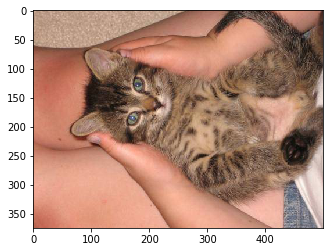

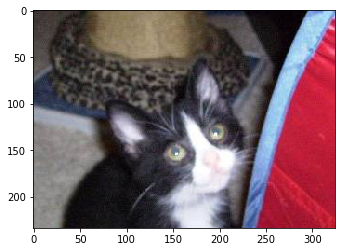

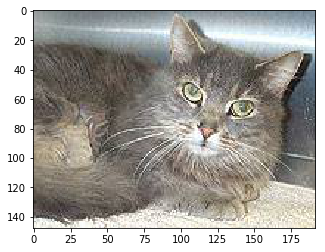

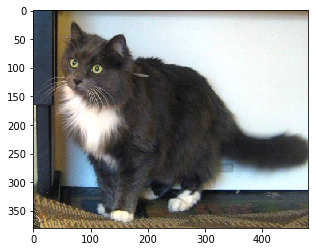

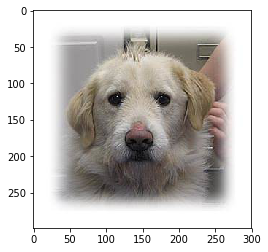

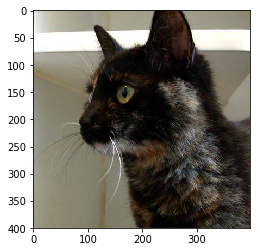

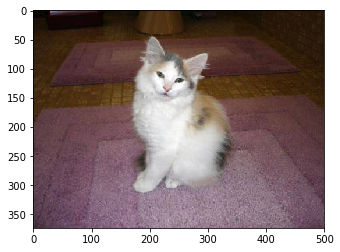

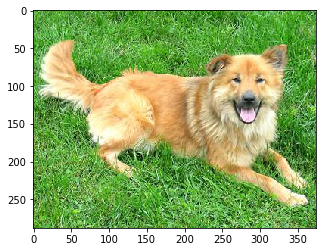

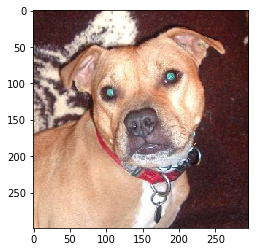

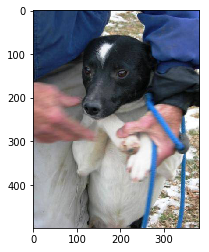

In [6]:
for i in range(len(dataset)*2): # loop twice to show that the second loop will shuffle data
    im = next(dataset)
    plt.imshow(im)
    plt.show()

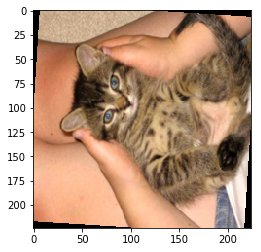

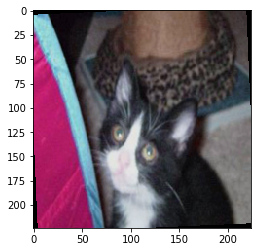

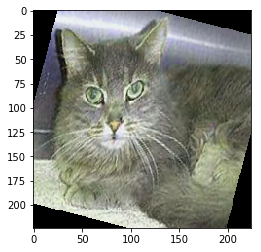

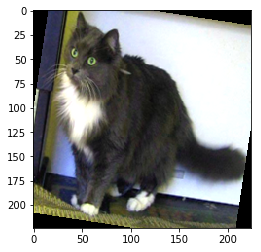

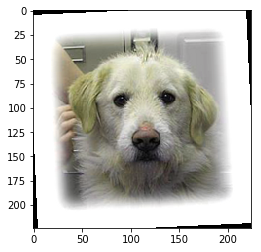

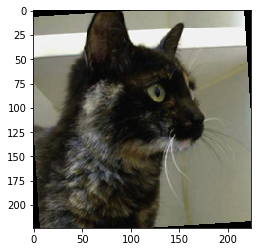

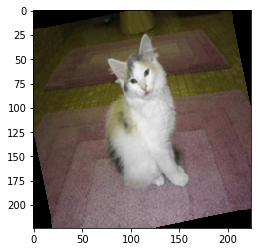

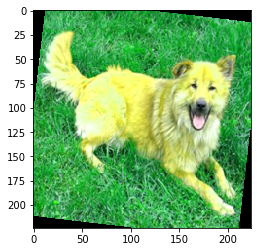

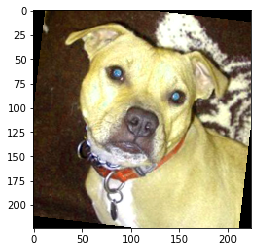

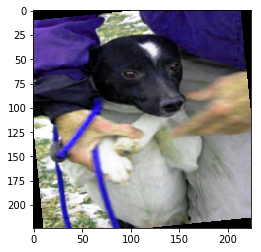

100%|██████████| 1000/1000 [00:11<00:00, 86.10it/s]

Elapse time: 11.6179 secs


In [7]:
# Use Augmentation functions in Pytorch

py_tra = transforms.Compose([
    transforms.ToPILImage(), # convert nd-array to PIL image
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=0.1, saturation=0.1, brightness=0.1, contrast=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15, resample=Image.BICUBIC)
])

dataset = Pytorch_dataset_method(file_list=image_path, transform=py_tra)
for i in range(len(dataset)):
    im = dataset[i]
    plt.imshow(im)
    plt.show()
    
start_time = time.time()
for i in tqdm(range(1000)):
    im = dataset[i]
end_time = time.time()
print("Elapse time: %.4f secs" % (end_time-start_time))

In [8]:
class Imgaug_transform():
    def __init__(self):
        self.aug = iaa.Sequential([iaa.Scale((224,224)),
                                   iaa.Sometimes(0.5, iaa.AddToHueAndSaturation(value=(-15, 15), per_channel=True) ),
                                   iaa.Fliplr(0.5),
                                   iaa.Affine(rotate=(-15, 15), mode='wrap')
                                   ])
    def __call__(self, img):
        return self.aug.augment_image(img)
    
#imgaug_tra = transforms.Compose([
#    Imgaug_transform()
#])
imgaug_tra = Imgaug_transform()

dataset = Pytorch_dataset_method(file_list=image_path, transform=imgaug_tra)

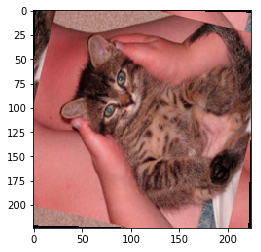

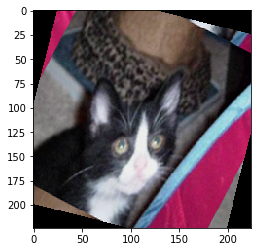

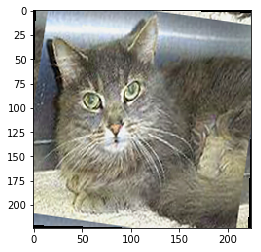

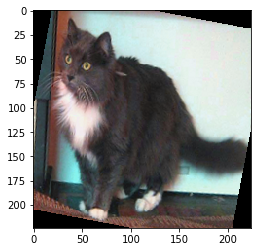

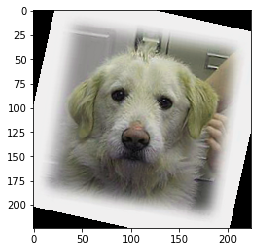

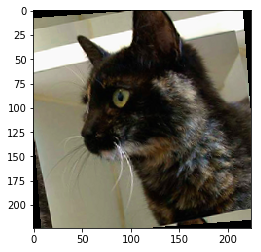

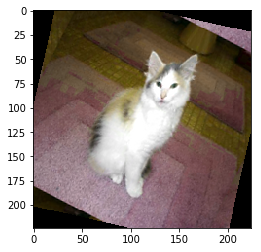

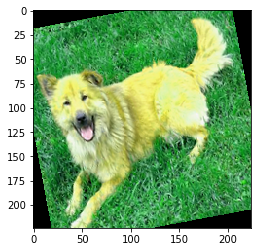

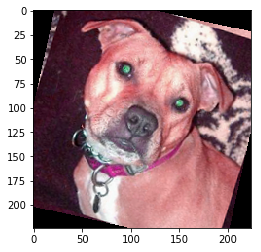

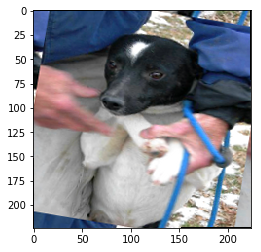

100%|██████████| 1000/1000 [00:13<00:00, 73.57it/s]

Elapse time: 13.5962 secs


In [16]:
for i in range(len(dataset)):
    im = dataset[i]
    plt.imshow(im)
    plt.show()
    
start_time = time.time()
for i in tqdm(range(1000)):
    im = dataset[i]
end_time = time.time()
print("Elapse time: %.4f secs" % (end_time-start_time))

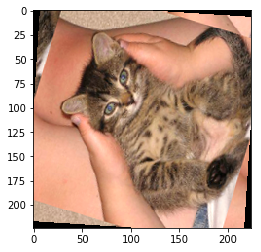

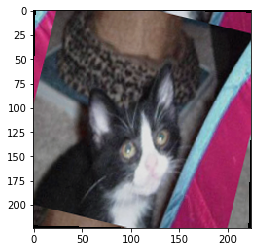

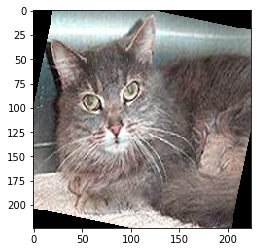

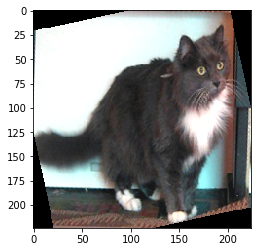

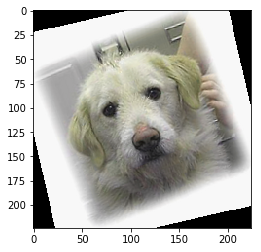

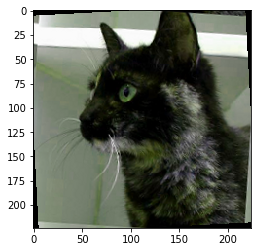

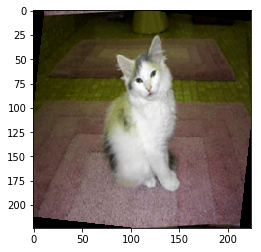

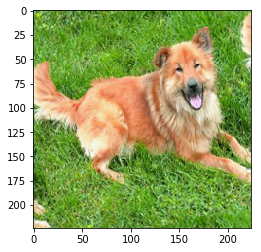

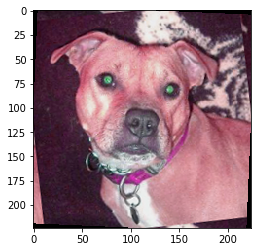

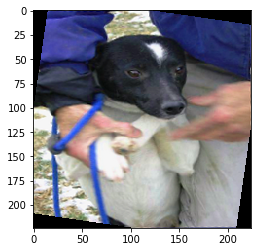

100%|██████████| 1000/1000 [00:14<00:00, 69.58it/s]

Elapse time: 14.3744 secs


In [27]:
# Mix two kinds of method together
mix_tra = transforms.Compose([
    Imgaug_transform(),
    transforms.ToPILImage(), # convert nd-array to PIL image
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=0.1, saturation=0.1, brightness=0.1, contrast=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15, resample=Image.BICUBIC),
    transforms.ToTensor()
])

dataset = Pytorch_dataset_method(file_list=image_path, transform=mix_tra)
for i in range(len(dataset)):
    im = dataset[i]
    plt.imshow(im.numpy().transpose((1,2,0)))
    plt.show()
    
start_time = time.time()
for i in tqdm(range(1000)):
    im = dataset[i]
end_time = time.time()
print("Elapse time: %.4f secs" % (end_time-start_time))

In [28]:
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=24,
                                         num_workers=4,
                                         pin_memory=True)

In [29]:
tmp = next(iter(dataloader))
tmp.shape

torch.Size([10, 3, 224, 224])